# Setup & Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from wordcloud import WordCloud
from collections import Counter

# Settings
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.2f}".format)

# 1. Load and Merge Datasets

In [2]:
movies = pd.read_csv("data/tmdb_5000_movies.csv")
credits = pd.read_csv("data/tmdb_5000_credits.csv")

df = movies.merge(credits, left_on="id", right_on="movie_id", how="inner")
df = df[['budget','genres','original_title','overview','popularity','production_companies',
         'release_date','revenue','runtime','vote_average','vote_count','cast','crew']]

print(f"Dataset shape: {df.shape}")
df.head(1)

Dataset shape: (4803, 13)


,budget,genres,original_title,overview,popularity,production_companies,release_date,revenue,runtime,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",Avatar,"In the 22nd century, a paraplegic Marine is di...",150.44,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",2009-12-10,2787965087,162.00,7.20,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


# 2. Data Cleaning & Preparation

In [3]:
def clean_data(data):
    data = data.copy()
    # Remove entries with zero budget or revenue
    data = data[(data['budget'] > 0) & (data['revenue'] > 0)]
    data.dropna(subset=['runtime', 'release_date'], inplace=True)

    # Date conversion
    data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')
    data['year'] = data['release_date'].dt.year
    
    # Extract genres
    data['genres'] = data['genres'].apply(ast.literal_eval).apply(
        lambda x: [d['name'] for d in x] if isinstance(x, list) else []
    )
    
    # Extract directors from crew
    data['crew'] = data['crew'].apply(ast.literal_eval)
    data['director'] = data['crew'].apply(
        lambda x: next((d['name'] for d in x if d['job'] == 'Director'), None)
    )
    
    # Extract main actors from cast (first 3)
    data['cast'] = data['cast'].apply(ast.literal_eval)
    data['main_actors'] = data['cast'].apply(
        lambda x: [d['name'] for d in x[:3]] if isinstance(x, list) else []
    )

    # Financial metrics
    data['profit'] = data['revenue'] - data['budget']
    data['ROI'] = np.where(data['budget'] != 0, data['profit'] / data['budget'], 0)
    
    return data

df = clean_data(df)
print(f"After cleaning: {df.shape}")
df.head(3)

After cleaning: (3229, 18)


,budget,genres,original_title,overview,popularity,production_companies,release_date,revenue,runtime,vote_average,vote_count,cast,crew,year,director,main_actors,profit,ROI
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",Avatar,"In the 22nd century, a paraplegic Marine is di...",150.44,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",2009-12-10,2787965087,162.00,7.20,11800,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",2009,James Cameron,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",2550965087,10.76
1,300000000,"[Adventure, Fantasy, Action]",Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.08,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",2007-05-19,961000000,169.00,6.90,4500,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",2007,Gore Verbinski,"[Johnny Depp, Orlando Bloom, Keira Knightley]",661000000,2.20
2,245000000,"[Action, Adventure, Crime]",Spectre,A cryptic message from Bond’s past sends him o...,107.38,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",2015-10-26,880674609,148.00,6.30,4466,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de...",2015,Sam Mendes,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",635674609,2.59


# 3. Descriptive Statistics

In [4]:
print("Descriptive Statistics for Key Metrics:")
df.describe()[['budget','revenue','profit','runtime','vote_average','vote_count','ROI']]

Descriptive Statistics for Key Metrics:


,budget,revenue,profit,runtime,vote_average,vote_count,ROI
count,"3,229.00","3,229.00","3,229.00","3,229.00","3,229.00","3,229.00","3,229.00"
mean,"40,654,444.77","121,242,957.26","80,588,512.49",110.72,6.31,977.29,"2,953.82"
min,1.00,5.00,"-165,710,090.00",41.00,0.00,0.00,-1.00
25%,"10,500,000.00","17,000,000.00","211,394.00",96.00,5.80,178.00,0.02
50%,"25,000,000.00","55,184,721.00","26,165,571.00",107.00,6.30,471.00,1.30
75%,"55,000,000.00","146,292,009.00","97,489,822.00",121.00,6.90,"1,148.00",3.42
max,"380,000,000.00","2,787,965,087.00","2,550,965,087.00",338.00,8.50,"13,752.00","8,499,999.00"
std,"44,396,741.80","186,302,864.01","158,147,947.47",20.97,0.87,"1,414.31","150,610.10"


# 4. Genre Analysis

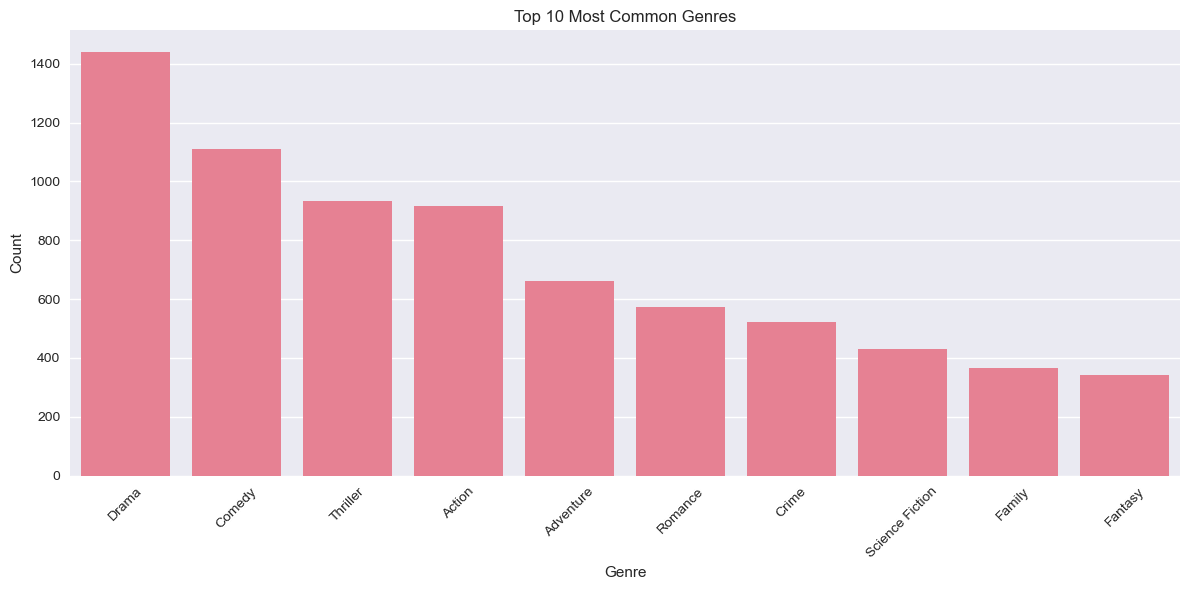

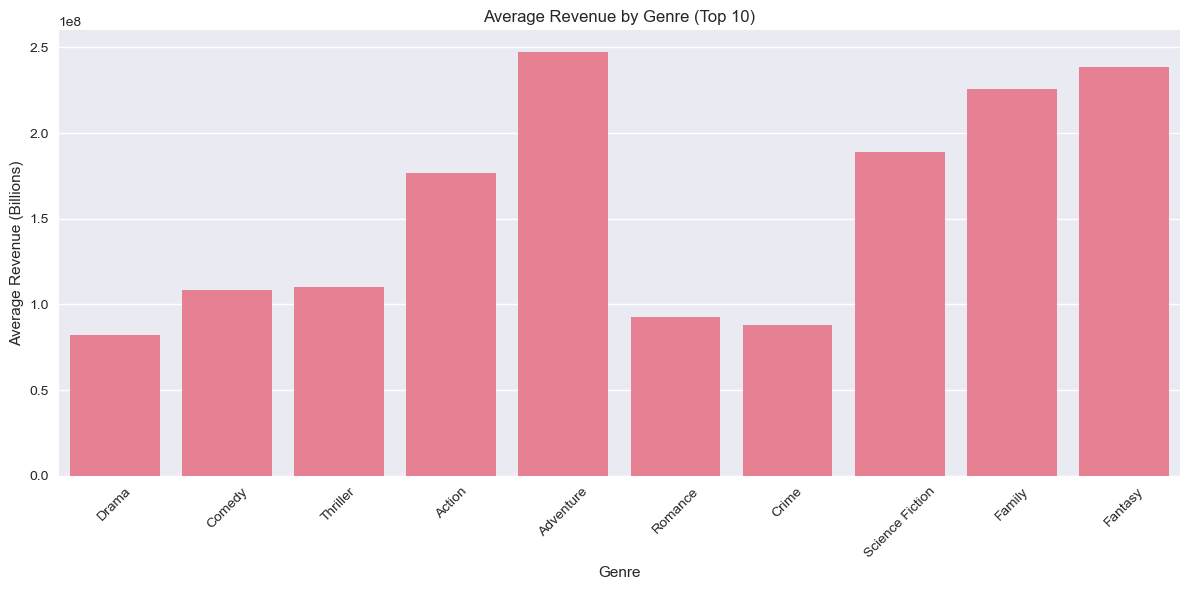

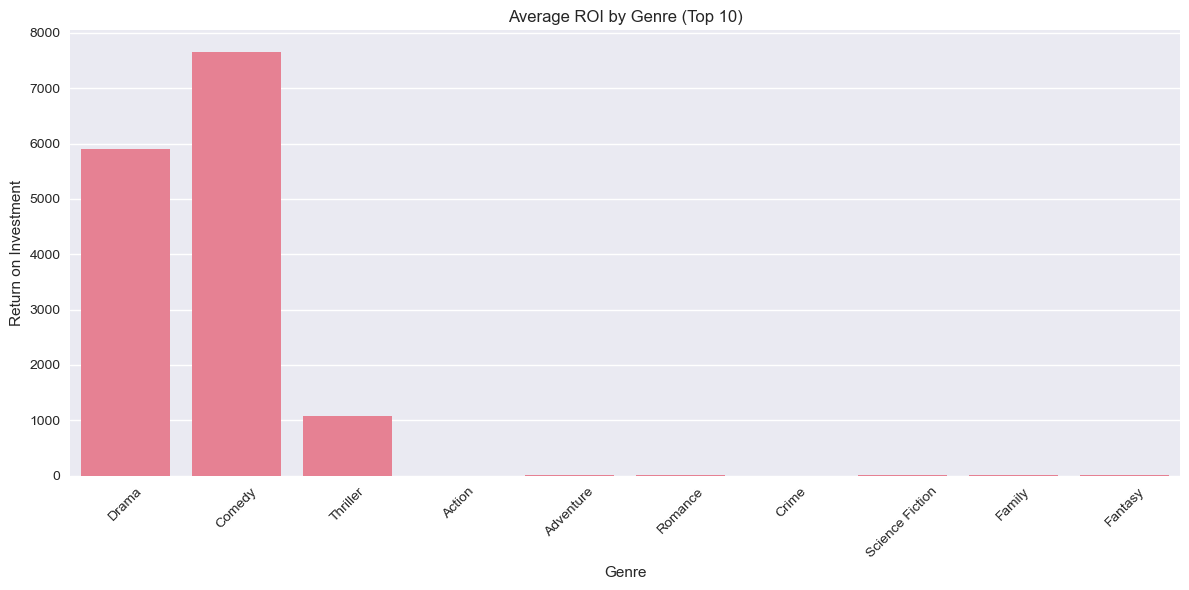

In [5]:
# Get all genres and their counts
all_genres = [genre for sublist in df['genres'] for genre in sublist]
genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

# Top 10 most common genres
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_df.head(10), x='Genre', y='Count')
plt.title("Top 10 Most Common Genres")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Average revenue and ROI by genre
genre_stats = []
for genre in genre_df['Genre'].head(10):
    genre_movies = df[df['genres'].apply(lambda x: genre in x)]
    avg_revenue = genre_movies['revenue'].mean()
    avg_roi = genre_movies['ROI'].mean()
    genre_stats.append({
        'Genre': genre,
        'Avg_Revenue': avg_revenue,
        'Avg_ROI': avg_roi,
        'Movie_Count': len(genre_movies)
    })

genre_stats_df = pd.DataFrame(genre_stats)

# Plot average revenue by genre
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_stats_df, x='Genre', y='Avg_Revenue')
plt.title("Average Revenue by Genre (Top 10)")
plt.xticks(rotation=45)
plt.ylabel("Average Revenue (Billions)")
plt.tight_layout()
plt.show()

# Plot average ROI by genre
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_stats_df, x='Genre', y='Avg_ROI')
plt.title("Average ROI by Genre (Top 10)")
plt.xticks(rotation=45)
plt.ylabel("Return on Investment")
plt.tight_layout()
plt.show()

# 5. Time Trends

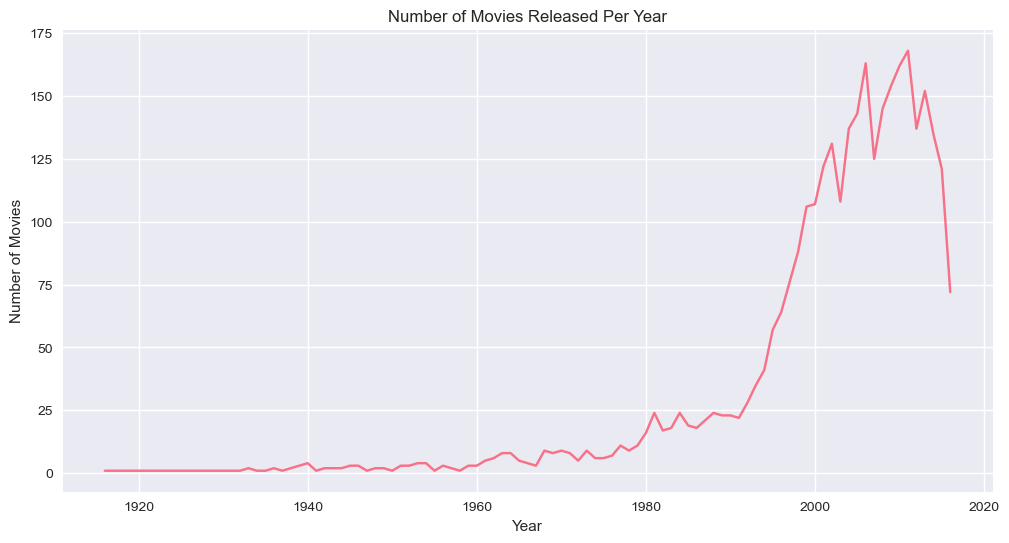

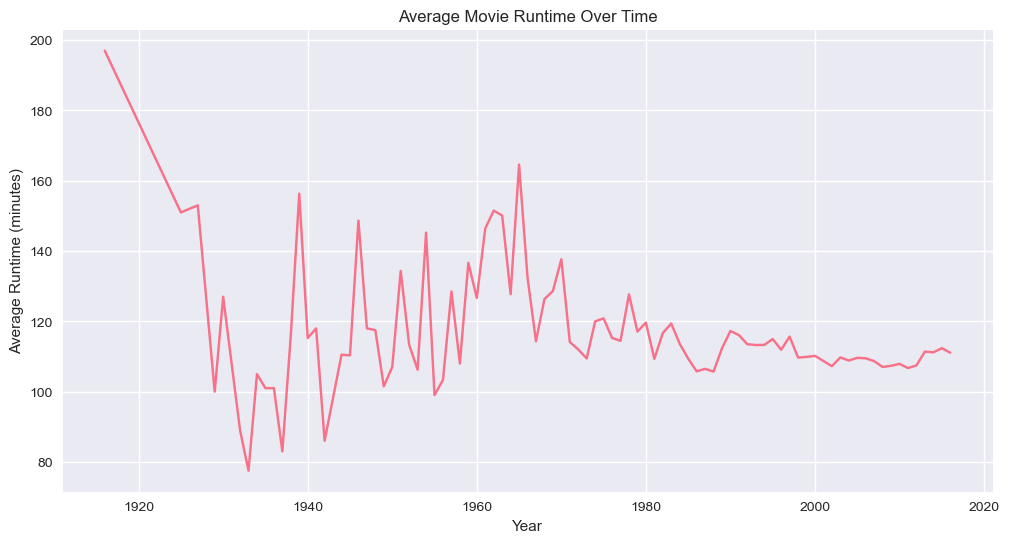

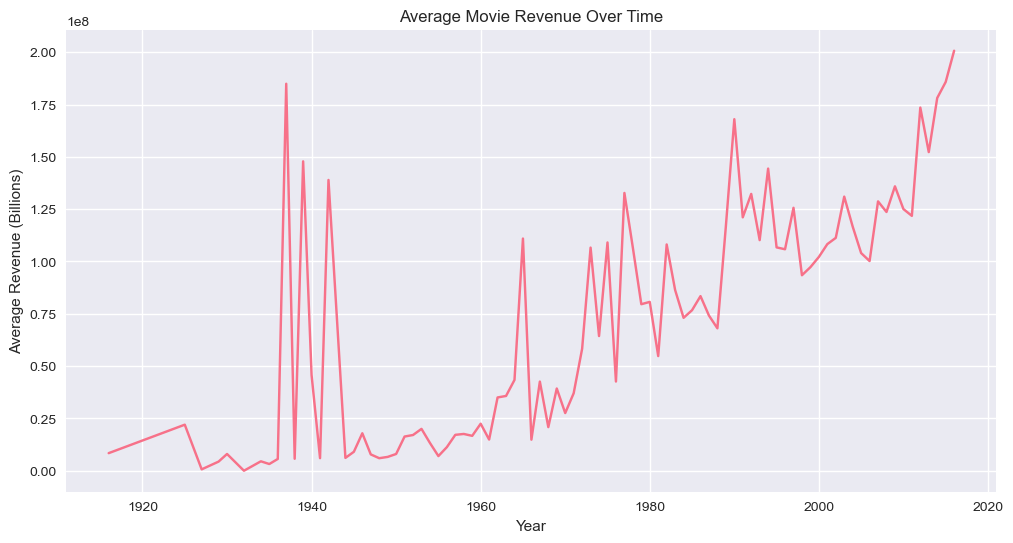

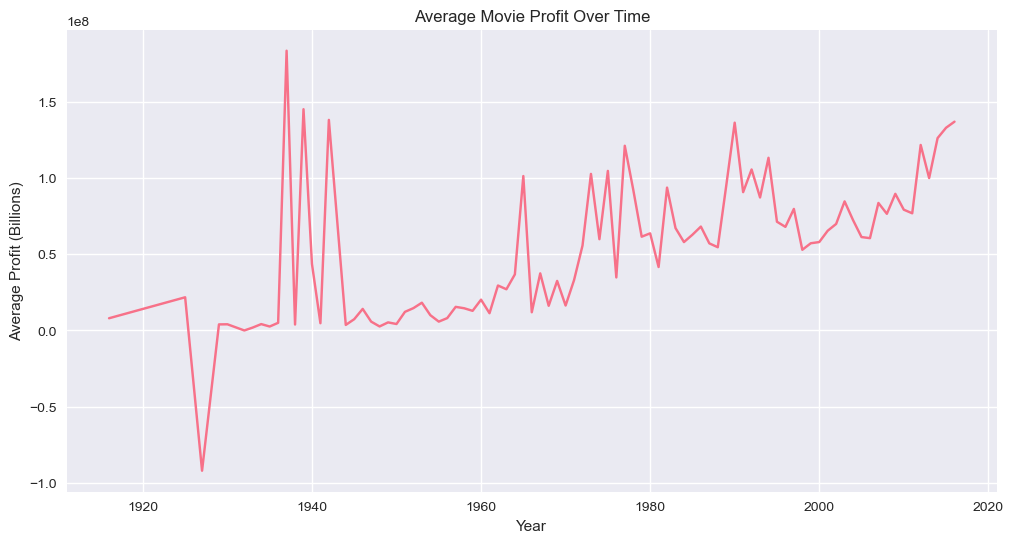

In [6]:
# Movies per year
movies_per_year = df.groupby('year').size()

plt.figure(figsize=(12, 6))
movies_per_year.plot(kind='line')
plt.title("Number of Movies Released Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.grid(True)
plt.show()

# Average runtime over time
runtime_trend = df.groupby('year')['runtime'].mean()

plt.figure(figsize=(12, 6))
runtime_trend.plot(kind='line')
plt.title("Average Movie Runtime Over Time")
plt.xlabel("Year")
plt.ylabel("Average Runtime (minutes)")
plt.grid(True)
plt.show()

# Revenue trends over time
revenue_trend = df.groupby('year')['revenue'].mean()

plt.figure(figsize=(12, 6))
revenue_trend.plot(kind='line')
plt.title("Average Movie Revenue Over Time")
plt.xlabel("Year")
plt.ylabel("Average Revenue (Billions)")
plt.grid(True)
plt.show()

# Profit trends over time
profit_trend = df.groupby('year')['profit'].mean()

plt.figure(figsize=(12, 6))
profit_trend.plot(kind='line')
plt.title("Average Movie Profit Over Time")
plt.xlabel("Year")
plt.ylabel("Average Profit (Billions)")
plt.grid(True)
plt.show()

# 6. Financial Analysis

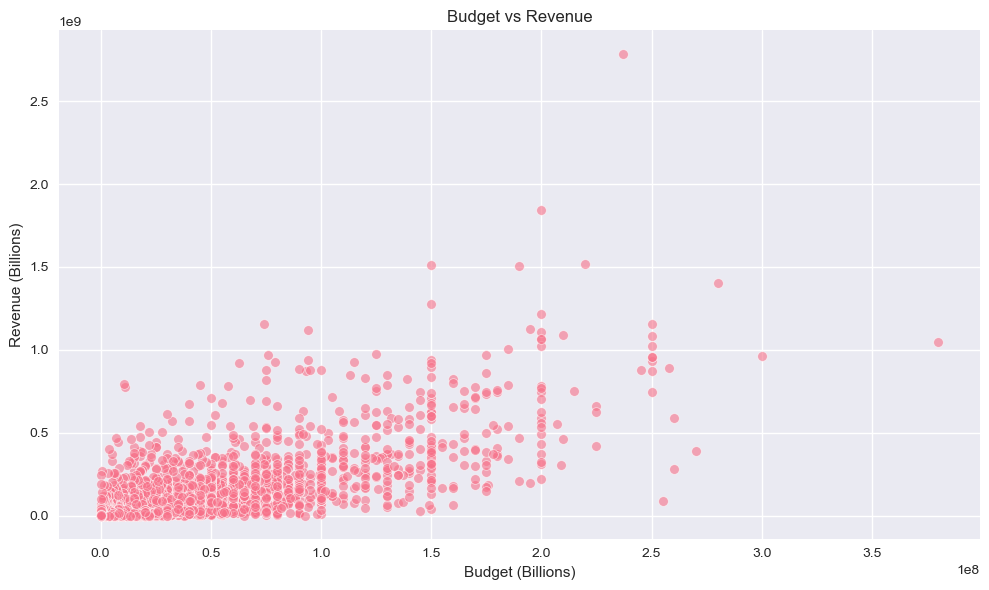

Correlation between budget and revenue: 0.705


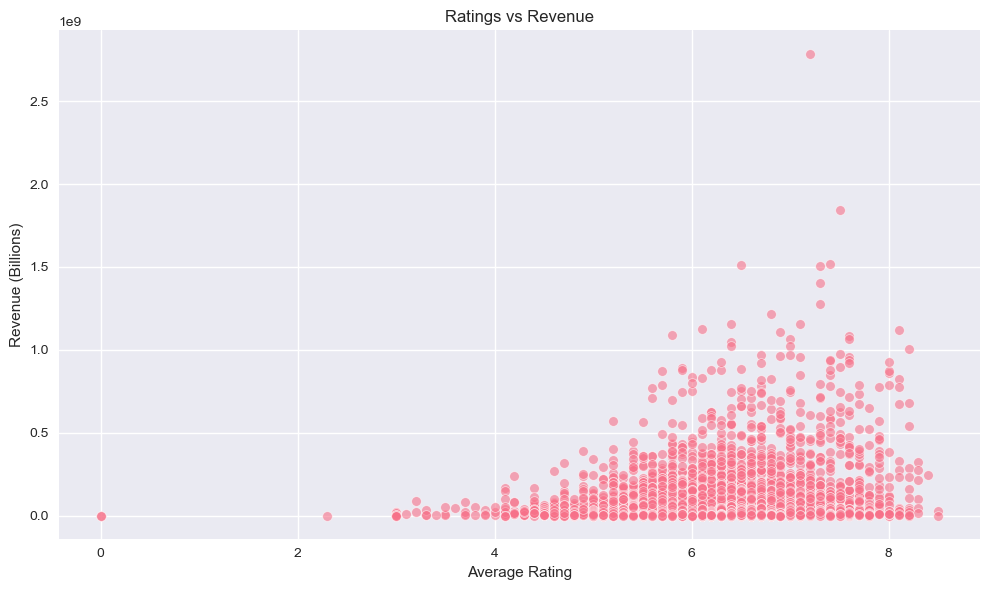

Correlation between ratings and revenue: 0.188


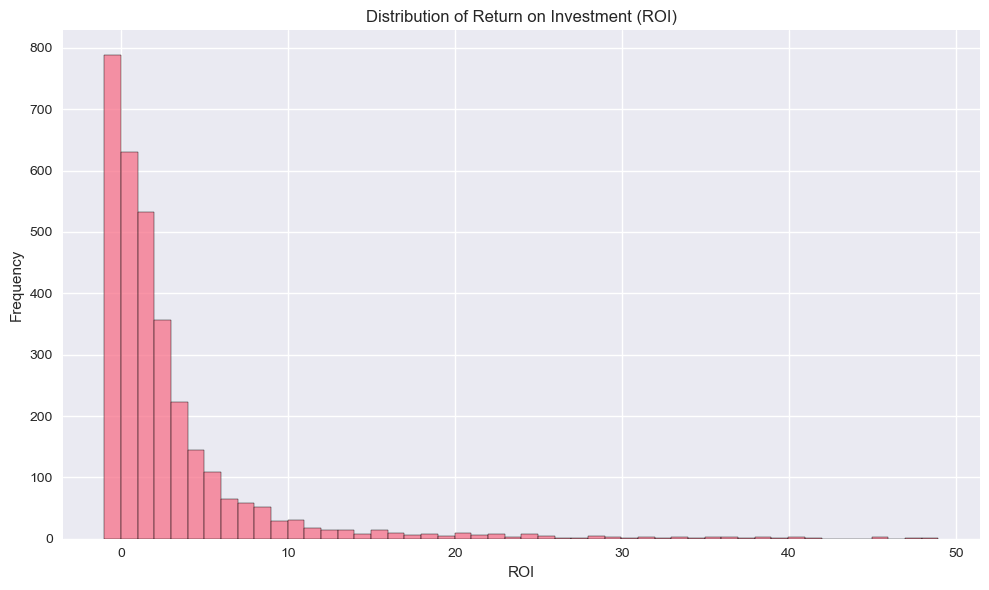

In [7]:
# Budget vs Revenue scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='budget', y='revenue', alpha=0.6)
plt.title("Budget vs Revenue")
plt.xlabel("Budget (Billions)")
plt.ylabel("Revenue (Billions)")
plt.tight_layout()
plt.show()

# Calculate correlation
budget_revenue_corr = df['budget'].corr(df['revenue'])
print(f"Correlation between budget and revenue: {budget_revenue_corr:.3f}")

# Ratings vs Revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='vote_average', y='revenue', alpha=0.6)
plt.title("Ratings vs Revenue")
plt.xlabel("Average Rating")
plt.ylabel("Revenue (Billions)")
plt.tight_layout()
plt.show()

# Calculate correlation
rating_revenue_corr = df['vote_average'].corr(df['revenue'])
print(f"Correlation between ratings and revenue: {rating_revenue_corr:.3f}")

# ROI distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df[df['ROI'] < 50], x='ROI', bins=50)  # Filter outliers for better visualization
plt.title("Distribution of Return on Investment (ROI)")
plt.xlabel("ROI")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 7. Top Directors and Actors Analysis

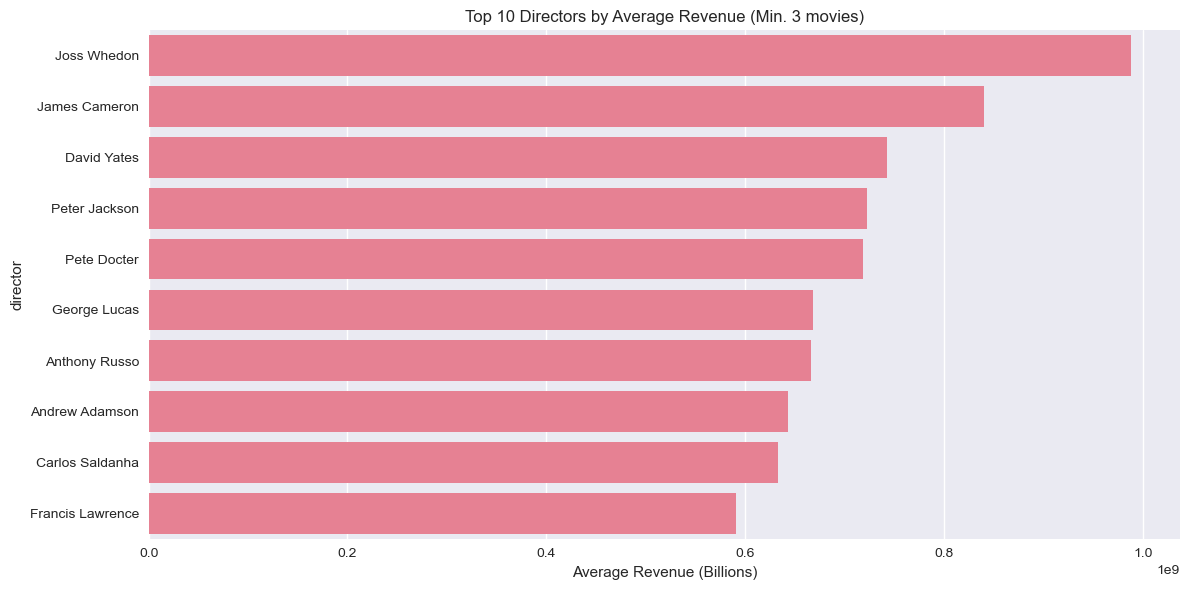

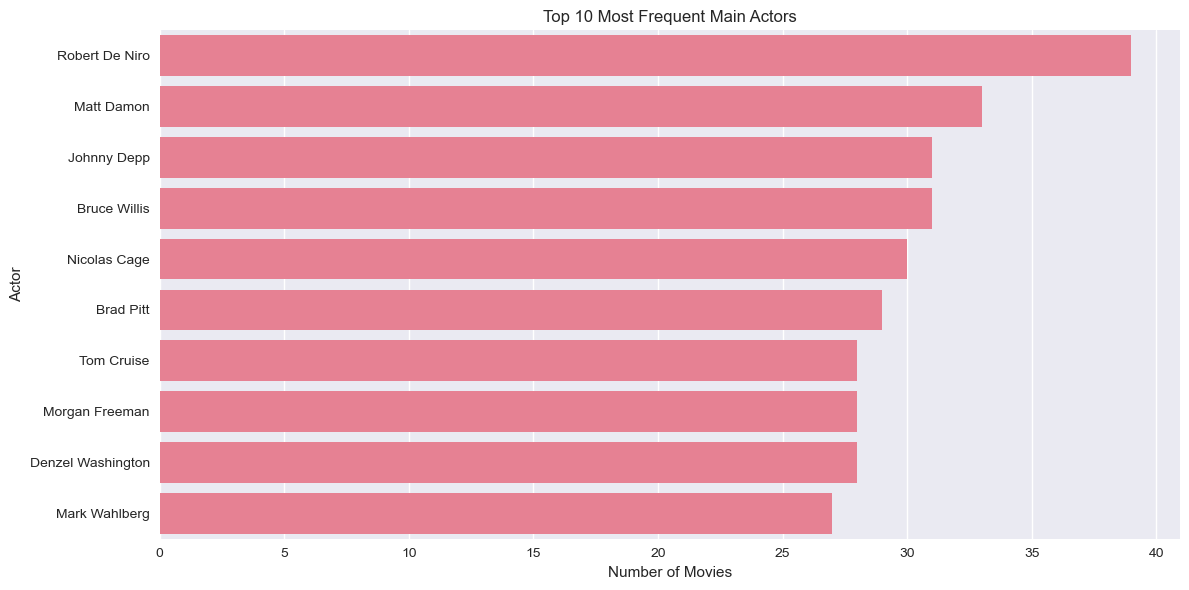

In [8]:
# Top 10 directors by average revenue
director_stats = df.groupby('director').agg({
    'revenue': 'mean',
    'vote_average': 'mean',
    'original_title': 'count'
}).rename(columns={'original_title': 'movie_count'})

top_directors = director_stats[director_stats['movie_count'] >= 3].nlargest(10, 'revenue')

plt.figure(figsize=(12, 6))
sns.barplot(data=top_directors.reset_index(), x='revenue', y='director')
plt.title("Top 10 Directors by Average Revenue (Min. 3 movies)")
plt.xlabel("Average Revenue (Billions)")
plt.tight_layout()
plt.show()

# Top actors analysis (appearing in main cast)
all_actors = [actor for sublist in df['main_actors'] for actor in sublist]
actor_counts = Counter(all_actors)
top_actors = pd.DataFrame(actor_counts.items(), columns=['Actor', 'Movie_Count']).nlargest(10, 'Movie_Count')

plt.figure(figsize=(12, 6))
sns.barplot(data=top_actors, x='Movie_Count', y='Actor')
plt.title("Top 10 Most Frequent Main Actors")
plt.xlabel("Number of Movies")
plt.tight_layout()
plt.show()

# 8. Correlation Heatmap

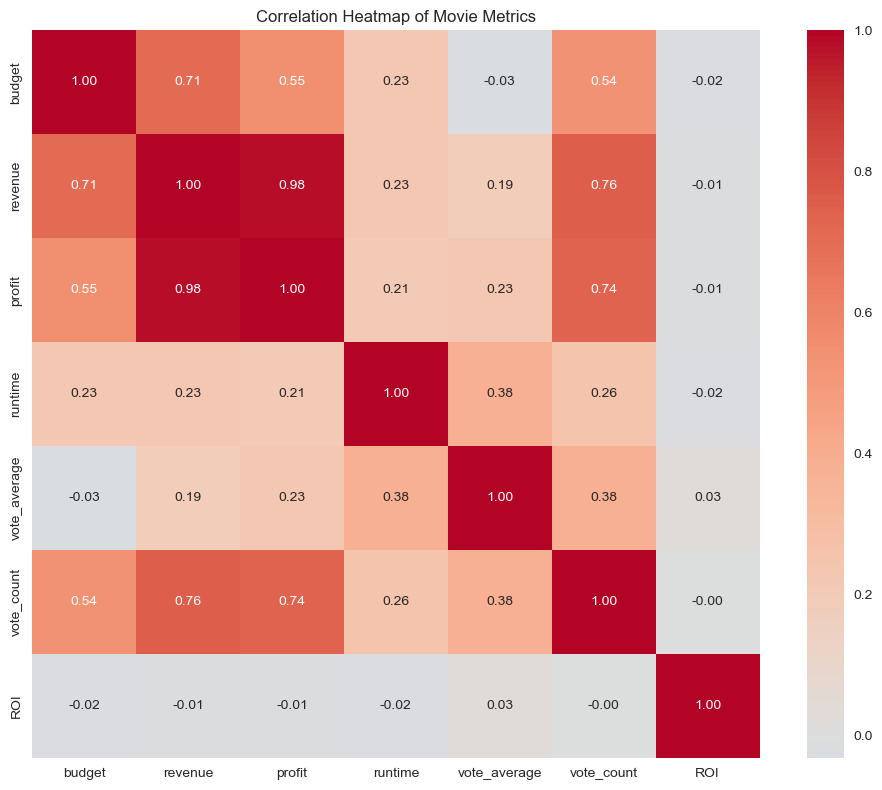

In [9]:
# Select numerical columns for correlation
numerical_cols = ['budget', 'revenue', 'profit', 'runtime', 'vote_average', 'vote_count', 'ROI']
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title("Correlation Heatmap of Movie Metrics")
plt.tight_layout()
plt.show()

# 9. Word Cloud Analysis

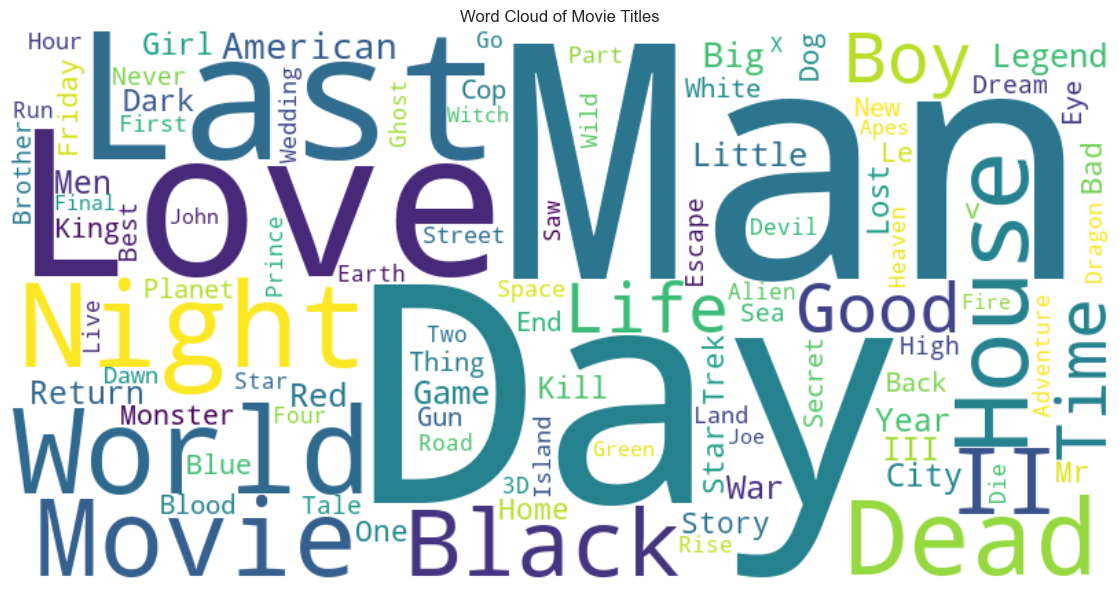

In [10]:
# Combine all movie titles
all_titles = ' '.join(df['original_title'].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      colormap='viridis', max_words=100).generate(all_titles)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Movie Titles")
plt.tight_layout()
plt.show()

# 10. Key Insights Summary

In [11]:
print("="*60)
print("KEY INSIGHTS SUMMARY")
print("="*60)

# Insight 1: Most profitable genres
profitable_genres = genre_stats_df.nlargest(3, 'Avg_ROI')
print(f"\n1. Most Profitable Genres (by ROI):")
for _, row in profitable_genres.iterrows():
    print(f"   - {row['Genre']}: {row['Avg_ROI']:.2f} ROI")

# Insight 2: Budget-Revenue relationship
print(f"\n2. Budget-Revenue Correlation: {budget_revenue_corr:.3f}")
print("   → Higher budget generally leads to higher revenue")

# Insight 3: Rating-Revenue relationship  
print(f"\n3. Rating-Revenue Correlation: {rating_revenue_corr:.3f}")
print("   → Higher ratings don't always guarantee higher revenue")

# Insight 4: Time trends
recent_profit = df[df['year'] >= 2010]['profit'].mean()
older_profit = df[df['year'] < 2010]['profit'].mean()
profit_change = ((recent_profit - older_profit) / older_profit) * 100

print(f"\n4. Profit Trends:")
print(f"   - Average profit for movies since 2010: ${recent_profit:,.0f}")
print(f"   - Average profit for movies before 2010: ${older_profit:,.0f}")
print(f"   - Change: {profit_change:+.1f}%")

# Insight 5: Top performing metrics correlation
strongest_corr = correlation_matrix.unstack().sort_values(ascending=False)
strongest_corr = strongest_corr[strongest_corr < 0.999].head(3)  # Remove self-correlations

print(f"\n5. Strongest Correlations:")
for pair, value in strongest_corr.items():
    print(f"   - {pair[0]} vs {pair[1]}: {value:.3f}")

print("\n" + "="*60)

KEY INSIGHTS SUMMARY

1. Most Profitable Genres (by ROI):
   - Comedy: 7662.07 ROI
   - Drama: 5907.02 ROI
   - Thriller: 1073.90 ROI

2. Budget-Revenue Correlation: 0.705
   → Higher budget generally leads to higher revenue

3. Rating-Revenue Correlation: 0.188
   → Higher ratings don't always guarantee higher revenue

4. Profit Trends:
   - Average profit for movies since 2010: $106,193,973
   - Average profit for movies before 2010: $69,962,583
   - Change: +51.8%

5. Strongest Correlations:
   - revenue vs profit: 0.980
   - profit vs revenue: 0.980
   - revenue vs vote_count: 0.756

